In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

## Étape 1: dataset

La première étape consiste à définir une classe, la classe LabelSet, pour stocker les données d'apprentissage, de validation et de test. Nous considérerons que les données tiennent en mémoire.

La classe LabelSet sert donc à stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy.

In [2]:
class LabeledSet:  
    """ Classe pour représenter un ensemble d'exemples (base d'apprentissage)
        Variables d'instance :
            - input_dimension (int) : dimension de la description d'un exemple (x)
            - nb_examples (int) : nombre d'exemples dans l'ensemble
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de LabeledSet
            Argument: 
                - intput_dimension (int) : dimension de x
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        """ Ajout d'un exemple dans l'ensemble
            Argument: 
                - vector ()
                - label (int) : classe de l'exemple (+1 ou -1)
            
        """
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    def getInputDimension(self):
        """ Renvoie la dimension de l'espace d'entrée
        """
        return self.input_dimension
    
    def size(self):
        """ Renvoie le nombre d'exemples dans l'ensemble
        """
        return self.nb_examples
    
    def getX(self, i):
        """ Renvoie la description du i-eme exemple (x_i)
        """
        return self.x[i]
    
    #
    def getY(self, i):
        """ Renvoie la classe de du i-eme exemple (y_i)
        """
        return(self.y[i])

In [3]:
# Exemple d'utilisation de LabeledSet

une_base = LabeledSet(2)        # définition d'une base pour contenir des exemples en 2D
une_base.addExample([0, 1],1)   # ajout de l'exemple (0, 1) de classe +1
une_base.addExample([2, 3],1)   # ajout de l'exemple (2, 3) de classe +1
une_base.addExample([1, 2],-1)  # ajout de l'exemple (1, 2) de classe -1
une_base.addExample([2, 2],-1)  # ajout de l'exemple (2, 2) de classe -1


In [4]:
def affiche_base(ls):
    size = ls.size()
    for i in range (size):
        print("Exemple : ",i)
        print("Description : ",ls.getX(i))
        print("Classe : ", ls.getY(i))
        print("\n")

In [5]:
affiche_base(une_base)

Exemple :  0
Description :  [0 1]
Classe :  [1]


Exemple :  1
Description :  [2 3]
Classe :  [1]


Exemple :  2
Description :  [1 2]
Classe :  [-1]


Exemple :  3
Description :  [2 2]
Classe :  [-1]




Un dataset en 2 dimensions pourra être affiché en utilisant matplotlib et plus précisément la fonction `matplotlib.pyplot.scatter` permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    plt.scatter(S_pos[:,0],S_pos[:,1],marker='o') # 'o' pour la classe +1
    plt.scatter(S_neg[:,0],S_neg[:,1],marker='x') # 'x' pour la classe -1


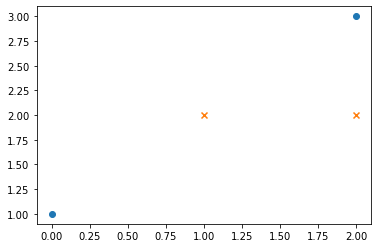

In [7]:
# Par exemple :
plot2DSet(une_base)

### Génération de données ''Jouet''

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main. 

Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in \{-1;+1\}$ tel que les données sont générées selon deux gaussiennes. Pour cela, nous utiliserons la fonction `numpy.random.multivariate_normal` - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html

- `positive_center` est le centre de la gaussienne des points positifs (vecteur de taille 2)
- `positive_sigma` est la variance de la gaussienne des points positifs (sous forme de matrice 2*2)
- `negative_center` est le centre de la gaussienne des points négative (vecteur de taille 2)
- `negative_sigma` est la variance de la gaussienne des points négative (sous forme de matrice 2*2)
- `nb_points` est le nombre de points de chaque classe à générer

rend un dataset généré aléatoirement.

In [8]:
def createGaussianDataset(positive_center,positive_sigma,negative_center,negative_sigma,nb_points):
    ls = LabeledSet(2)
    
    positive_test = np.random.multivariate_normal(positive_center,positive_sigma,nb_points)
    negative_test = np.random.multivariate_normal(negative_center,negative_sigma,nb_points)
    

    for i in range (nb_points):
        ls.addExample(positive_test[i],1)
        ls.addExample(negative_test[i],-1)

    return ls
    

Taille de la base jouet générée : 20 exemples


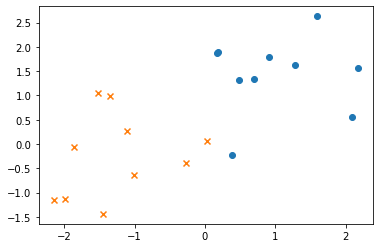

In [9]:
# Exemple d'utilisation:

the_set = createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),10)

print("Taille de la base jouet générée :", the_set.size(), "exemples")

# Affichage :
plot2DSet(the_set)


## Étape 2: les classifieurs

Un classifieur (binaire dans ce cours) permet, pour chaque point d'entrée donné, de calculer un score. Si le score est négatif, la donnée est associée à la classe $-1$, sinon à la classe $+1$. 

Les classifieurs que l'on va implémenter seront définis à l'aide d'une classe qui va dériver de la classe Classifier suivante. Cette classe est une classe "abstraite", elle sera dérivée par héritage pour définir des classifieurs particuliers (knn, arbres de décision, etc.).

Par conséquent, pour l'instant les méthodes `train` et `predict` ne seront pas définies car elles dépendent du modèle que l'on choisira.

Par contre, la fonction `computeAccuracy` renvoie le pourcentage de points bien classés.

In [10]:
class Classifier:
    """ Classe pour représenter un classifieur
        Attention: cette classe est une classe abstraite, elle ne peut pas être
        instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
            Hypothèse : input_dimension > 0
        """
        raise NotImplementedError("Please Implement this method")
        
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        raise NotImplementedError("Please Implement this method")

    def train(self, labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        
        raise NotImplementedError("Please Implement this method")
    
    def accuracy(self, dataset):
        """ Permet de calculer la qualité du système 
        """
        
        size = dataset.size()
        good_result = 0
        
        for i in range (size):
            prediction = self.predict(dataset.getX(i))
            result = dataset.getY(i)
            #print("Prediction : ",prediction," // Result : ",result)
            if ( prediction == result ):
                good_result += 1
            
        
        probability_good_result = good_result / size 
        pourcentage_good_result = (good_result * 100) / size
        
        return pourcentage_good_result

Nous allons maintenant définir un **classifieur linéaire aléatoire** en étendant la classe Classifier et en implémentant le constructeur ainsi que les 2 méthodes `predict` et `train`.

Pour un classifieur linéaire aléatoire:
- dans le constructeur, on doit générer aléatoirement un vecteur $w$ de taille `input_dimension` aléatoirement
- pour ce classifieur, la méthode `train` ne fait rien. On ne mettra qu'un print permettant d'afficher le message "Pas d'apprentissage pour ce classifieur"
- pour une description d'exemple $x$, la méthode `predict` doit utiliser la valeur de $\langle x | w\rangle$ pour prédire le label (+1 ou -1) associé


In [11]:
class ClassifierRandom(Classifier):
    """ Classe pour représenter un classifieur linéaire aléatoire
        Cette classe hérite de la classe Classifier
    """
    
    def __init__(self, input_dimension):
        self.w = np.random.rand(1,input_dimension)
        self.input_dimension = input_dimension
    
    def train(self, labeledSet):
        print("Pas d'entrainement pour ce classificateur")
    
    
    def predict(self, x):
        res = 0
        for i in range (self.input_dimension):
            res += x[i] * self.w[0][i]
        
        if res >= 0:
            return 1
        else:
            return -1
        
    #TODO: définir le constructeur, et les méthodes predict et train

np.random.rand(1,2)

array([[0.00823118, 0.65234829]])

In [12]:
# Création d'un classifieur linéaire aléatoire de dimension 2:
un_classifieur = ClassifierRandom(2)
the_set00 = createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),50)


La performance (*accuracy*) d'un classifieur linéaire aléatoire sur un ensemble de 100 points générés aléatoirement.

In [13]:
un_classifieur.accuracy(the_set00)

86.0

Voici une fonction qui permet de dessiner la frontière de decision d'un classifieur. La valeur `step` permet de choisir la précision du dessin.

In [14]:
def plot_frontiere(set,classifier,step=10):
    """ LabeledSet * Classifier * int -> NoneType
        Remarque: le 3e argument est optionnel et donne la "résolution" du tracé
        affiche la frontière de décision associée au classifieur
    """
    mmax=set.x.max(0)
    mmin=set.x.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    plt.contourf(x1grid,x2grid,res,colors=["red","cyan"],levels=[-1000,0,1000])

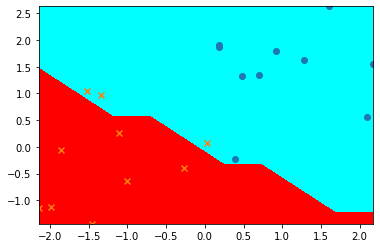

In [15]:
classifieur_random=ClassifierRandom(2)

plot_frontiere(the_set,classifieur_random)
plot2DSet(the_set)

## Étape 3 : k-NN

De la même façon que nous avons défini un classifieur aléatoire, nosu allons maintenant un classifieur par $k$ plus proches voisins (ou k-NN). 

Pour cela nous allons construire un tableau de distances que nous trierons grâce à la méthode `numpy.argsort`.

Pour un classifieur linéaire aléatoire:
- dans le constructeur, on préciser, en plus de la dimension, le nombre de voisins à utiliser (valeur de $k$)
- dans la méthode `train`, on constitue la base de points de référence en mémorisant le LabeledSet donné
- pour une description d'exemple $x$, la méthode `predict` doit construire un tableau de distances aux points de référence, puis le trier grâce à la méthode `numpy.argsort`.


In [16]:
class ClassifierKNN(Classifier):
    
    def __init__(self,input_dimension,neighbors):
        self.k = neighbors
        self.input_dimension = 2
        
    def train(self,labeledSet):
        self.ls = labeledSet
        
        
    def predict(self,x):
        size = self.ls.size()
        dist_table = np.array([-1,-1])
        
        for i in range (size):
            lsX = self.ls.getX(i)
            dist = 0
            
            for j in range(self.input_dimension):
                dist += (lsX[j] - x[j])**2
            
            
            to_add = np.array([i,dist])
            dist_table = np.vstack((dist_table,to_add))
        
        #dist_table = np.argsort(dist_table,axis=0)
        dist_table = dist_table[dist_table[:, 1].argsort()]
        
        #print("\n",dist_table)
        
        resultat = 0
        for i in range (self.k):
            indice = int(dist_table[i+1][0])
            lsY = self.ls.getY(indice)
            resultat += lsY
            
            #print(indice,lsY)
            
        if(resultat >= 0):
            return 1
        else:
            return -1
            
        
        
knn = ClassifierKNN(2,1)
knn.train(the_set)    


In [17]:
knn = ClassifierKNN(2,1)
knn.train(the_set)

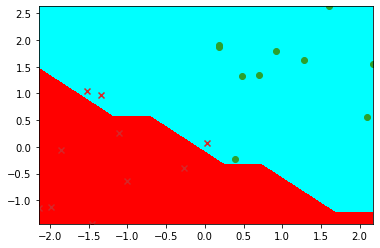

In [18]:
# Exemple d'utilisation :
knn = ClassifierKNN(2,1)
knn.train(the_set)

plot_frontiere(the_set,knn,20)
plot2DSet(the_set) 

plot_frontiere(the_set,classifieur_random)
plot2DSet(the_set)

knn_training_set = createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
the_set00 = createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),15)


## Étape 4: protocole expérimental

Attention, lorsque l'on évalue un classifieur, il est nécessaire de considérer deux ensembles distincts: un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'apprentissage).

Size set : 30
Accuracy KNN :  96.66666666666667
Accuracy RANDOM :  93.33333333333333
KNN is better
[[0.2830711  0.81587422]]


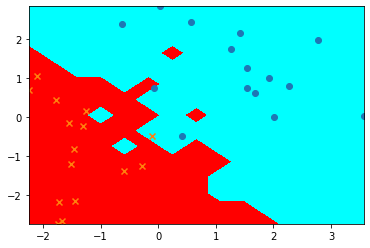

In [19]:

knn = ClassifierKNN(2,1)
knn.train(knn_training_set)

classifieur_random=ClassifierRandom(2)


knn_acc = knn.accuracy(the_set00)
random_acc = classifieur_random.accuracy(the_set00)

print("Size set :",the_set00.size())
print("Accuracy KNN : ",knn_acc)
print("Accuracy RANDOM : ",random_acc)

if(knn_acc > random_acc):
    print("KNN is better")
else:
    print("KNN isn't better")

print(classifieur_random.w)
plot_frontiere(the_set00,knn,15)
plot2DSet(the_set00) 

### Différentes expérimentations

Comparaison de la performance (en train et test) de plusieurs classifieurs KNN avec différentes valeurs de k.

In [20]:
for i in range (10):
    knn_training_set = createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),20)

    knn = ClassifierKNN(2,i)
    knn.train(knn_training_set)
    
    knn_acc = knn.accuracy(the_set00)
    
    print("Neighbors : ",i," // Accuracy : ",knn_acc)

"""On remarque qu'il existe un seuil d'inefficacité.
En efet après 6 / 7 voisins, l'algorithme prends du temps à calculer et ne fournit pas un résultat plus probant.
"""

Neighbors :  0  // Accuracy :  50.0
Neighbors :  1  // Accuracy :  96.66666666666667
Neighbors :  2  // Accuracy :  96.66666666666667
Neighbors :  3  // Accuracy :  90.0
Neighbors :  4  // Accuracy :  96.66666666666667
Neighbors :  5  // Accuracy :  86.66666666666667
Neighbors :  6  // Accuracy :  96.66666666666667
Neighbors :  7  // Accuracy :  100.0
Neighbors :  8  // Accuracy :  100.0
Neighbors :  9  // Accuracy :  96.66666666666667


"On remarque qu'il existe un seuil d'inefficacité.\nEn efet après 6 / 7 voisins, l'algorithme prends du temps à calculer et ne fournit pas un résultat plus probant.\n"

In [25]:
#Méthode très gourmande en calcul
HalfValues = 200
ls = createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),HalfValues)


def split(ls,pourcentageTest):
    
    taille = ls.size()
    nbTest = taille/pourcentageTest
    Input_dimension = ls.getInputDimension()
    
    if taille > 0:
        x = ls.getX(0)
        y = ls.getY(0)
        table = np.array([x,y])
        
    #On met sous la forme de np.array pour pouvoir shuffle
    for i in range (1,taille):
        x = ls.getX(i)
        y = ls.getY(i)
        table = np.vstack((table,[x,y]))
    
    # On shuffle pour avoir un bon echantillon
    np.random.shuffle(table)
    
    #On créait 2 LabeledSet pour reformer le tout.
    ls1 = LabeledSet(Input_dimension)
    ls2 = LabeledSet(Input_dimension)
    

    cpt = 0
    while(cpt < nbTest):
        ls2.addExample(table[cpt][0],table[cpt][1])
        cpt+=1
    while(cpt < taille):
        ls1.addExample(table[cpt][0],table[cpt][1])
        cpt+=1
    
    return (ls1,ls2)


<font color="RED" size="+1">**[Q]**</font> Tester différents k-NN , pour différentes valeurs de $k$, et tracer la courbe de performance (accuracy) pour les données d'apprentissage et les données de test.

In [ ]:
liste = split(ls,10)
lsApp = liste[0]
lsTest = liste[1]

knn = ClassifierKNN(2,i)
knn.train(lsApp)
knn_acc = knn.accuracy(lsTest)

print("KNN accuracy : ",knn_acc)
plot_frontiere(the_set00,knn,15)
plot2DSet(the_set00) 